In [1]:
from fscve_step1_db import FscveStep1DbHelper
dbhelper = FscveStep1DbHelper( "nm", "fcb", 5, False)
session = dbhelper.session
expid = dbhelper.experiment_id
benchmark = dbhelper.benchmark
fc = dbhelper.fc

print(f"{benchmark}----{fc}----{expid}")

nm----fcb----5


kaktest 5, fcb, nm
                fuzzer  edges_count  time
0     parmesan-0-exid4            0     0
1     parmesan-0-exid4            0     1
2     parmesan-0-exid4            0     2
3     parmesan-0-exid4            0     3
4     parmesan-0-exid4            0     4
...                ...          ...   ...
7125     fuzzer_global         1631  1421
7126     fuzzer_global         1631  1422
7127     fuzzer_global         1631  1423
7128     fuzzer_global         1631  1424
7129     fuzzer_global         1631  1425

[7130 rows x 3 columns]
                fuzzer  edges_count  time
0     parmesan-0-exid4            0     0
1  aflplusplus-0-exid4            0     0
2      radamsa-0-exid4            0     0
3        symcc-0-exid4            0     0
4        fuzzer_global            0     0
                   fuzzer  edges_count  time
0        parmesan-0-exid4            0     0
1     aflplusplus-0-exid4            0     0
2         radamsa-0-exid4            0     0
3           symcc-0-

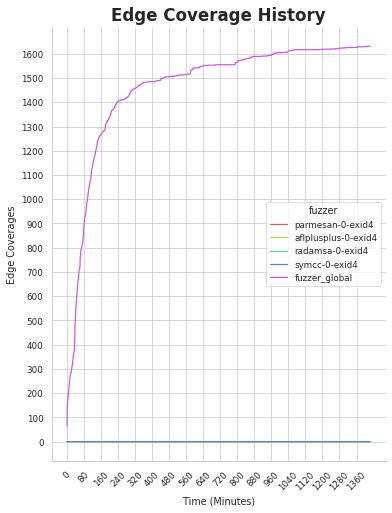

In [2]:
from sqlalchemy import func
from fscve_step1_db import  Fuzzer, Discovery, EdgeCoverageGlobal, EdgeCoverageFuzzer

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print(f"kaktest {expid}, {fc}, {benchmark}")

# 每分钟统计下各个fuzzer达到的覆盖和全局覆盖状况
query_fuzzers = session.query(Fuzzer).all()
fuzzers = [result.fuzzer_id for result in query_fuzzers ]  #fuzzer ids
fuzzers_name = [result.fuzzer_name for result in query_fuzzers ] #fuzzer names
last_time = session.query(Discovery.discovery_time).order_by(Discovery.discovery_time.desc()).first()  # maxtime
# from start recording ,Second as unit
# print(last_time.keys())
last_time = last_time['discovery_time']
start_time = session.query(Discovery.discovery_time).order_by(Discovery.discovery_time).first()
start_time = start_time['discovery_time']
#unit:minute
start_time //=60
last_time //=60

edges_fuzzers ={}
i = 0
dfs =[]
for fuzzer in fuzzers:
    edges_fuzzer = []
    for time in range(start_time,last_time+1):
        #edges covered by fuzzer untill time
        query_edge_fuzzer = session.query(func.count(Discovery.discovery_id).label("edges_count")).join(EdgeCoverageFuzzer,Discovery.discovery_id == EdgeCoverageFuzzer.discovery_id).filter(Discovery.discovery_time  <  (time+1)*60, Discovery.discovery_fuzzer == fuzzer).first()
        edges_fuzzer.append(query_edge_fuzzer.edges_count)
    # print(edges_fuzzer[last_time-1])
    dfs.append(pd.DataFrame({"fuzzer":[fuzzers_name[i] for t in range(start_time,last_time+1)],'edges_count':edges_fuzzer,"time":range(start_time,last_time+1)}))
    i+=1
# print(edges_fuzzers)

fuzzer_global = 520131417
fuzzers.append(fuzzer_global)
fuzzers_name.append(f"fuzzer_global")
edges_fuzzer = []
for time in range(start_time,last_time+1):
    query_edge_fuzzer = session.query(func.count(Discovery.discovery_id).label("edges_count")).join(EdgeCoverageGlobal,Discovery.discovery_id == EdgeCoverageGlobal.discovery_id).filter(Discovery.discovery_time  <  (time+1)*60).first()
    edges_fuzzer.append(query_edge_fuzzer.edges_count)

dfs.append(pd.DataFrame({"fuzzer":["fuzzer_global" for i in range(start_time,last_time+1)],'edges_count':edges_fuzzer,"time":range(start_time,last_time+1)}))

df_edge_coverage = pd.concat(dfs,ignore_index=True)
print(df_edge_coverage)

#fake time 0
df_top = pd.DataFrame({"fuzzer":[fuzzer for fuzzer in fuzzers_name],'edges_count':[0 for fuzzer in fuzzers_name],"time":[0 for fuzzer in fuzzers_name]})
print(df_top)

df_edge_coverage = pd.concat([df_top, df_edge_coverage]).reset_index(drop = True)
df_edge_coverage.set_index("time")
print(df_edge_coverage)
# df_edge_coverage.reset_index()
# df_edge_coverage.set_index("time")
path_full_csv = f"csv/fscve_edge_history_fuzzers_{benchmark}_{fc}_{expid}.csv"
df_edge_coverage.to_csv(path_full_csv)


plt.figure(figsize=((last_time+10)/(60 if last_time <= 400 else 120 if last_time <=800 else 240),8))

sns.set(style="whitegrid")
sns.set_context("paper")
sns.set_palette(sns.color_palette("hls",  len(fuzzers_name)))
sns.lineplot(x="time", y="edges_count", hue="fuzzer",data=df_edge_coverage)
# sns.lineplot(x="time", y="edges_count",data=df_edge_coverage)
sns.despine()

plt.xticks(ticks=range(0,last_time+10,20 if last_time <= 400 else 40 if last_time <=800 else 80),rotation = 45)
plt.yticks(ticks=range(0,edges_fuzzer[-1],100))
plt.xlabel("Time (Minutes)")
plt.ylabel("Edge Coverages")
plt.title('Edge Coverage History',fontsize='xx-large', fontweight='heavy')
plt.savefig(f"image/fuzzer_edge_coverage_history_{benchmark}_{fc}_{expid}.svg")
plt.show()


In [3]:
#get the time when max coverage achieved
fuzzer_global = 520131417
fuzzers.append(fuzzer_global)
fuzzers_name.append("fuzzer_global")
edges_fuzzer = []
for time in range(start_time,last_time+1):
    query_edge_fuzzer = session.query(func.count(Discovery.discovery_id).label("edges_count")).join(EdgeCoverageGlobal,Discovery.discovery_id == EdgeCoverageGlobal.discovery_id).filter(Discovery.discovery_time  <  (time+1)*60).first()
    edges_fuzzer.append(query_edge_fuzzer.edges_count)

idx = edges_fuzzer.index(max(edges_fuzzer))
time_found = start_time+idx
print(f'max coverage:{max(edges_fuzzer)} at time:{time_found}')

df_global = pd.DataFrame({"fuzzer":["fuzzer_global" for i in range(start_time,last_time+1)],'edges_count':edges_fuzzer,"time":range(start_time,last_time+1)})
# print(df_global)

path_global_edge_csv = f"csv/fscve_edge_history_global_{benchmark}_{fc}_{expid}.csv"
df_global.to_csv(path_global_edge_csv)

dict_value_benchmark = [benchmark]
dict_value_fuzzer_combination = [fc]
dict_value_experiment_id = [expid]
dict_value_edge_count = [max(edges_fuzzer)]
df_edge_count = pd.DataFrame({"benchmark":dict_value_benchmark, "fuzzer_combination":dict_value_fuzzer_combination, "experiment_id":dict_value_experiment_id, "edge_count":dict_value_edge_count})
df_edge_count.to_csv(f"csv/fscve_edge_count_global_{benchmark}_{fc}_{expid}.csv")
print(df_edge_count)


max coverage:1631 at time:1402
  benchmark fuzzer_combination  experiment_id  edge_count
0        nm                fcb              5        1631


In [ ]:
#calc the total unique edges of a fc on special benchmark
#for enfuzz,the old data collected didn't include edge-coverage-fuzzer db table
#so,it needs to obtain the info from edge-coverage-global,instead of fscve_edge_detail_{benchmark}_{fc}_{expid}.csv
print(f"{benchmark}----{fc}----{expid}")
query_edge_global = session.query(EdgeCoverageGlobal).all()
block_source = [result.block_source for result in query_edge_global]  #fuzzer ids
block_target = [result.block_target for result in query_edge_global] #fuzzer names
benchmarks = [benchmark for result in query_edge_global]
experimentid = [expid for result in query_edge_global]
fuzzer_combination = [fc for result in query_edge_global]
df_totalunique  = pd.DataFrame({"benchmark": benchmarks, "fuzzer_combination":  fuzzer_combination, "expid": experimentid, "block_source": block_source,  "block_target":block_target})
df_totalunique["edge"] = df_totalunique["block_source"].astype("str") + df_totalunique["block_target"].astype("str").map(lambda x:"-"+x)
df_totalunique.drop(["block_target", "block_source"],axis=1,inplace=True)
print(df_totalunique.shape[0])
# print(df_totalunique)
print(f"csv/fscve_step6_metric1_totalunique_{benchmark}_{fc}_{expid}.csv")
df_totalunique.to_csv(f"csv/fscve_step6_metric1_totalunique_{benchmark}_{fc}_{expid}.csv")

venn diagram should be drawn for 2+ objects


IndexError: index 0 is out of bounds for axis 0 with size 0

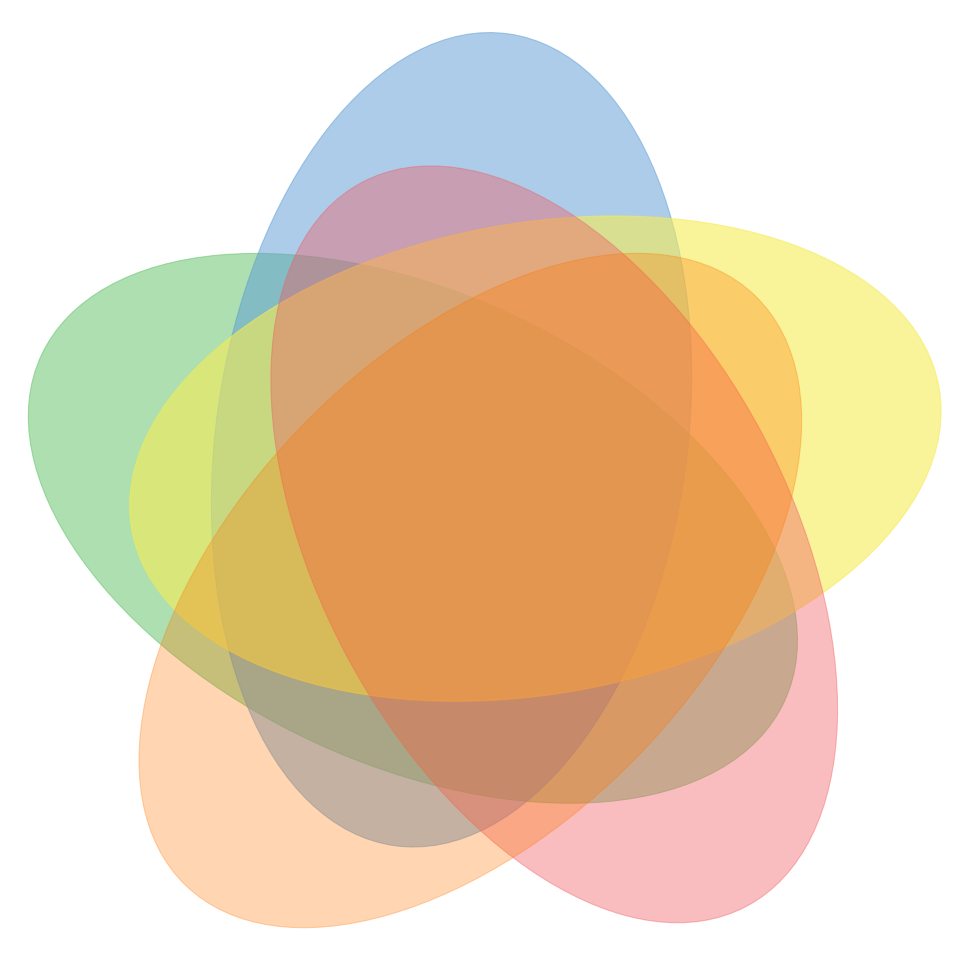

In [4]:
from pyvenn import venn

#venn diagram of fuzzers' edge coverage
# draw the venn diagram to visualize the unique or common bug findings
dict_fuzzer_edge_tag = {}
fuzzer_edge_tag = 1

from fscve_step1_db import EdgeCoverageFuzzer

# query coverage table from fuzzers
query = session.query(EdgeCoverageFuzzer.discovery_id,Fuzzer.fuzzer_name,EdgeCoverageFuzzer.block_source,EdgeCoverageFuzzer.block_target).join(Fuzzer,EdgeCoverageFuzzer.discovery_fuzzer_id == Fuzzer.fuzzer_id).all()
array_discovery_id = [result.discovery_id for result in query ]
array_fuzzer = [result.fuzzer_name for result in query ]
array_block_source = [result.block_source for result in query ]
array_block_target = [result.block_target for result in query ]

df_fuzzer_edge = pd.DataFrame({"discovery_id":array_discovery_id, "fuzzer":array_fuzzer, "block_source":array_block_source, "block_target":array_block_target},index=array_discovery_id)
# print(df_fuzzer_edge.columns)
# print(df_fuzzer_edge)

path_detail_edge_csv = f"csv/fscve_edge_detail_{benchmark}_{fc}_{expid}.csv"
df_fuzzer_edge.to_csv(path_detail_edge_csv)

def fuzzer_edge_to_tag(df):
    global dict_fuzzer_edge_tag,fuzzer_edge_tag
    for row_edge in df["discovery_id"]:
        # print(df.loc[row, "crash_frames_hash"])
        # print(dict_bug_tag.keys())
        edge_key = "{}-{}".format(df.loc[row_edge, "block_source"],df.loc[row_edge, "block_target"])
        if edge_key  not in dict_fuzzer_edge_tag.keys():
            dict_fuzzer_edge_tag[edge_key] = fuzzer_edge_tag
            fuzzer_edge_tag +=1

fuzzer_edge_to_tag(df_fuzzer_edge)
fuzzers = df_fuzzer_edge['fuzzer'].unique()
# print(fuzzers)
# print(dict_bug_tag)
dict_fuzzer_to_tags = {}

# get edge tags for every fuzzer
for fuzzer in fuzzers:
    tags = []
    df_tmp = df_fuzzer_edge[df_fuzzer_edge['fuzzer'] == fuzzer]
    for row_edge in df_tmp["discovery_id"]:
        edge_key = "{}-{}".format(df_tmp.loc[row_edge, "block_source"],df_tmp.loc[row_edge, "block_target"])
        tag = dict_fuzzer_edge_tag[edge_key]
        if tag not in tags:
            tags.append(tag)
    dict_fuzzer_to_tags[fuzzer] = tags

if len(fuzzers)<2:
    print("venn diagram should be drawn for 2+ objects")
    exit(0)


# limit fuzzer numbers to 6 for venn graphs
if len(fuzzers)>6:
    fuzzers=fuzzers[:6]

fuzzer_count = len(fuzzers)
#print(dict_fuzzer_to_tags)
venn_functions = [venn.venn2,venn.venn3,venn.venn4,venn.venn5,venn.venn6]
labels = venn.get_labels([dict_fuzzer_to_tags[fuzzers[i]] for i in range(0, fuzzer_count)], fill=['number', 'percent'])
func = venn_functions[fuzzer_count-2]
fig, ax = func(labels, names=fuzzers)
fig.savefig(f'image/fuzzer_edge_venn_{benchmark}_{fc}_{expid}.svg', bbox_inches='tight')